## Exploring metric stability

In this notebook, we show that:

1. With the standard set of agreement metrics (correlation, RMSE, $R^2$, QWK), the evaluation for a single automated score can give very different results depending on the pair of human raters that are used as the reference against which the system score is evaluated.

2. The PRMSE metric, on the other hand, yields stable evaluation results across different pairs of human raters.

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path
from simulation.dataset import Dataset
from simulation.utils import (compute_agreement_one_system_multiple_rater_pairs,
                               compute_prmse_one_system_multiple_rater_pairs,
                               get_rater_pairs)
from sklearn.metrics import r2_score

### Step 1: Setup

To set up the experiment, we do the following:

1. We load the dataset we have already created and saved in the `validation_and_analyses.ipynb` notebook and use that for this experiment.

2. We choose one of the simulated systems with high performance from this dataset as the source of our single automated score. 

3. We create a fixed number of randomly chosen human-rater pairs from our simulated raters, for each category.

For convenience and replicability, we have pre-computed many of the parameters that are used in our notebooks and saved them in the file `settings.json`. We load this file below.

In [2]:
# load the dataset file
dataset = Dataset.from_file('../data/default.dataset')

# let's remind ourselves what the dataset looks like
print(dataset)

Dataset (10000 responses, scores in [1, 6], 4 rater categories, 50 raters/category, 5 system categories, 5 systems/category)


In [3]:
# load the experimental settings file
experiment_settings = json.load(open('settings.json', 'r'))

In [4]:
# now get the data frames for our loaded dataset
df_scores, df_rater_metadata, df_system_metadata = dataset.to_frames()

# next let's get the ID of the simulated system that we have chosen
# as the source of our single automated score; this was pre-determined
# and saved in the settings file
chosen_system = experiment_settings['sample_system']

# finally, get the number of fixed human-rater pairs 
# per category that we want to use
rater_pairs_per_category = experiment_settings['rater_pairs_per_category']

In [5]:
# now let's get the pre-determined number of randomly-sampled pairs of raters in each rater category
rater_category_pairs = df_rater_metadata.groupby('rater_category').apply(lambda row: get_rater_pairs(row['rater_id'], rater_pairs_per_category))

### Step 2: Compute conventional agreement metrics

Next, we compute various conventional agreement metrics to measure the chosen system's performance against each pair of human raters in each category. Ideally, with a stable metric, one would not expect the estimate of performance of the **same** system to vary widely depending on which two _specific_ human raters were being used to evaluate it. For this experiment, we focus on the following agreement metrics that are commonly used for evaluating automated scoring systems:

1. Quadratically-weighted kappa (denoted by `QWK`)
2. Pearson's correlation (denoted by `r`)
3. $R^2$ (denoted by `R2`)
4. The difference between the human-human Pearson correlation and the human-machine Pearson correlation (denoted by `degradation`)

In [6]:
# initialize a list that will hold the dataframe of metrics computed for each rater category
category_dfs = []

# now iterate over each rater category
for rater_category in rater_category_pairs.index:
    
    # compute the data frame containing the conventional agreement metrics
    # this dataframe contains `N_r` * 2 rows, where `N_r` is the number of
    # rater pairs we sampled earlier in each category. There are 2 rows
    # because for each pair of raters, we compute the chosen system's performance
    # against: (a) the score assigned by the first human rater in the pair and
    # (b) the average of the scores assigned by both raters in the pair
    df_metrics_for_category = compute_agreement_one_system_multiple_rater_pairs(df_scores,
                                                                                chosen_system,
                                                                                rater_category_pairs[rater_category],
                                                                                include_mean=True)
    
    # save the category itself for later use
    df_metrics_for_category['rater_category'] = rater_category
    
    # save the data frame in the list
    category_dfs.append(df_metrics_for_category)

# create a single data frame by concatenating all of these frames
df_metrics_with_categories = pd.concat(category_dfs)

# now create a longer version of this data frame more amenable to plotting
df_metrics_with_categories_long =  df_metrics_with_categories.melt(id_vars=['reference', 'rater_category'], var_name='metric')

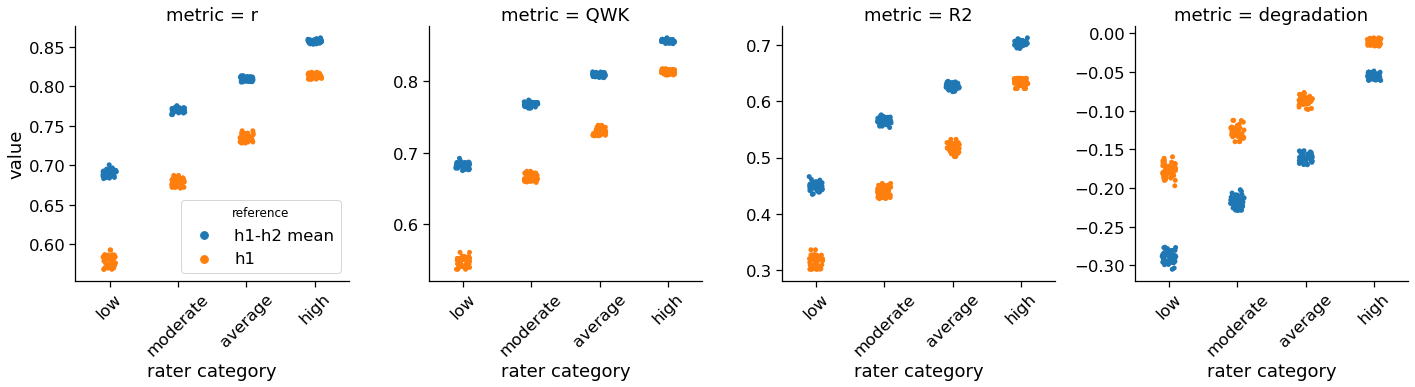

In [7]:
# now create a plot of the these convenational metrics by rater category
with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.catplot(x='rater_category', 
                    y='value',
                    kind='strip',
                    hue='reference',
                    col="metric",
                    data=df_metrics_with_categories_long,
                    col_order=['r', 'QWK', 'R2', 'degradation'],
                    order=dataset.rater_categories,
                    legend_out=False,
                    sharey=False)
    g.set_axis_labels("rater category", "value")
    g.set_xticklabels(dataset.rater_categories, rotation=45)
    plt.show()

We see from the plot that the behavior of the conventional agreement metrics is actually far from ideal. Their estimates of the same system's performance vary depending not only on the category from which the two simulated raters are chosen but also, to a lesser extent, on _which_ two specific raters are chosen from that category. Note that the plots will be a little different each time the above cell is run because of the random jitter added to make the dots not overlap with each other. However, this does not impact our interpretation.

We can also look at average values in tabular format.

In [8]:
# group by metric, the evaluation reference, and the rater category
grouper = df_metrics_with_categories_long.groupby(['metric',
                                                   'reference',
                                                   'rater_category'])['value']
# compute the mean, reformat, and reorder
grouper.mean().unstack()[dataset.rater_categories]

rater_category               low  moderate   average      high
metric      reference                                         
QWK         h1          0.547853  0.666112  0.730357  0.813188
            h1-h2 mean  0.682284  0.767889  0.809369  0.856459
R2          h1          0.315704  0.439609  0.516935  0.632639
            h1-h2 mean  0.449658  0.565152  0.626349  0.702588
degradation h1         -0.177214 -0.126635 -0.086549 -0.011377
            h1-h2 mean -0.289228 -0.217583 -0.160722 -0.055033
r           h1          0.578681  0.678744  0.735397  0.813347
            h1-h2 mean  0.690695  0.769692  0.809570  0.857004

### Step 3: Compute PRMSE metric

Next, we compute the proposed PRMSE metric for the same system against the same set of raters in each cateogry.

In [9]:
# initialize an empty dataframe
df_prmse_with_categories = pd.DataFrame()

# iterate over all rater categories and compute the PRMSE values for all rater pairs in that category
for rater_category in rater_category_pairs.index:
    prmse_values_for_category = compute_prmse_one_system_multiple_rater_pairs(df_scores, chosen_system, rater_category_pairs[rater_category])
    df_prmse_with_categories[rater_category] = prmse_values_for_category

# now create a longer version of this data frame more amenable to plotting
df_prmse_with_categories_long = df_prmse_with_categories.melt(var_name='rater_category')
df_prmse_with_categories_long['metric'] = 'PRMSE'

In [10]:
# now combine this data frame with the previous long data frame containing the other metrics
# except we only want to keep those metric values computed against the rater1-rater2 average scores
df_metrics_with_categories_long_only_average = df_metrics_with_categories_long[df_metrics_with_categories_long['reference'] == 'h1-h2 mean']

# and now we don't need the reference column anymore
df_metrics_with_categories_long_only_average = df_metrics_with_categories_long_only_average.drop('reference', axis=1)

# combine the metrics into a single data frame
df_all_metrics_long = pd.concat([df_metrics_with_categories_long_only_average, df_prmse_with_categories_long])

The first thing we can do is to compute some descriptive statistics for all of the metrics across all rater categories.

In [11]:
df_all_metrics_long.groupby('metric')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
PRMSE,200.0,0.791218,0.009080,0.762230,0.787005,0.791126,0.796642,0.822187
QWK,200.0,0.779000,0.064242,0.675206,0.744972,0.789610,0.823241,0.861024
R2,200.0,0.585937,0.092898,0.434688,0.531423,0.596121,0.649570,0.712106
degradation,200.0,-0.180642,0.086026,-0.304916,-0.240833,-0.185949,-0.128914,-0.048654
r,200.0,0.781740,0.061186,0.683164,0.748357,0.790528,0.823504,0.861549


The table shows that the variation in the PRMSE metric is significantly lower than the other, conventional agreement metrics. We can also look at this graphically by comparing PRMSE to one of the other metrics in detail, say, $R^2$.

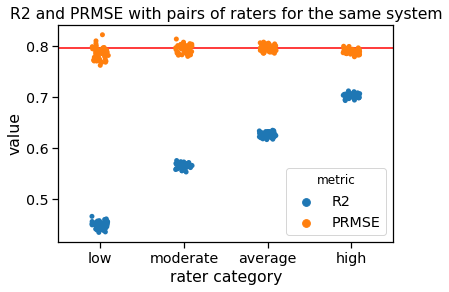

In [12]:
# now plot the values of the PRMSE and R^2 metrics by rater category
with sns.plotting_context('notebook', font_scale=1.3):
    ax = sns.stripplot(x='rater_category',
                       y='value', 
                       hue="metric",
                       order=dataset.rater_categories,
                       jitter=True,
                       data=df_all_metrics_long[df_all_metrics_long['metric'].isin(['R2', 'PRMSE'])])

    # we also add a line for the R^2 metric for the system scores
    # against the simulated true/gold-standard scores
    true_r2 = r2_score(df_scores['true'], df_scores[chosen_system])
    ax.axhline(true_r2, color='red')

    # set axis labels
    ax.set_title("R2 and PRMSE with pairs of raters for the same system")
    ax.set_xlabel("rater category");
    plt.show()

We can see from the plot and the table that the PRMSE metric is much more stable and helps keep the evaluation consistent across rater pairs. Note that the plot will be a little different each time the above cell is run because of the random jitter added to make the dots not overlap with each other. However, this does not impact our interpretation.